In [2]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from utils.plot_utils import combine_pdf_big

from open_ephys.analysis import Session
from pathlib import Path
import glob

import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from hdmf_zarr.nwb import NWBZarrIO
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps
from utils.combine_tools import apply_qc
import pandas as pd
import pickle
import scipy.stats as stats
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial
import time
import spikeinterface as si
import shutil 
import seaborn as sns
import math  
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import zscore
from trimesh import load_mesh
from scipy.optimize import minimize
from scipy.linalg import null_space
from joblib import Parallel, delayed

%matplotlib inline

In [3]:
criteria_name = 'waveform_TT'
waveform_version = '_raw' # 'wf_2D' for 'wf_2D_raw'

In [4]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
wf_folder = os.path.join('/root/capsule/scratch/combined/wf_plots', criteria_name, waveform_version)
if not os.path.exists(wf_folder):
    os.makedirs(wf_folder)

target_folder = '/root/capsule/scratch/manuscript/F_waveform_tetrode'


Applying bounds for isi_violations: [0.0, 0.5]
 - isi_violations: 18300 -> 11635 units passed
Applying items for qc_pass: [True]
 - qc_pass: 11635 -> 8492 units passed
Applying bounds for peak_raw: ['NaN', -50]
 - peak_raw: 8492 -> 945 units passed
Applying items for probe: ['tt']
 - probe: 945 -> 191 units passed
Applying conditional bounds for y_loc
 - y_loc: 191 -> 191 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 113
Number of non-opto rows after filtering: 191


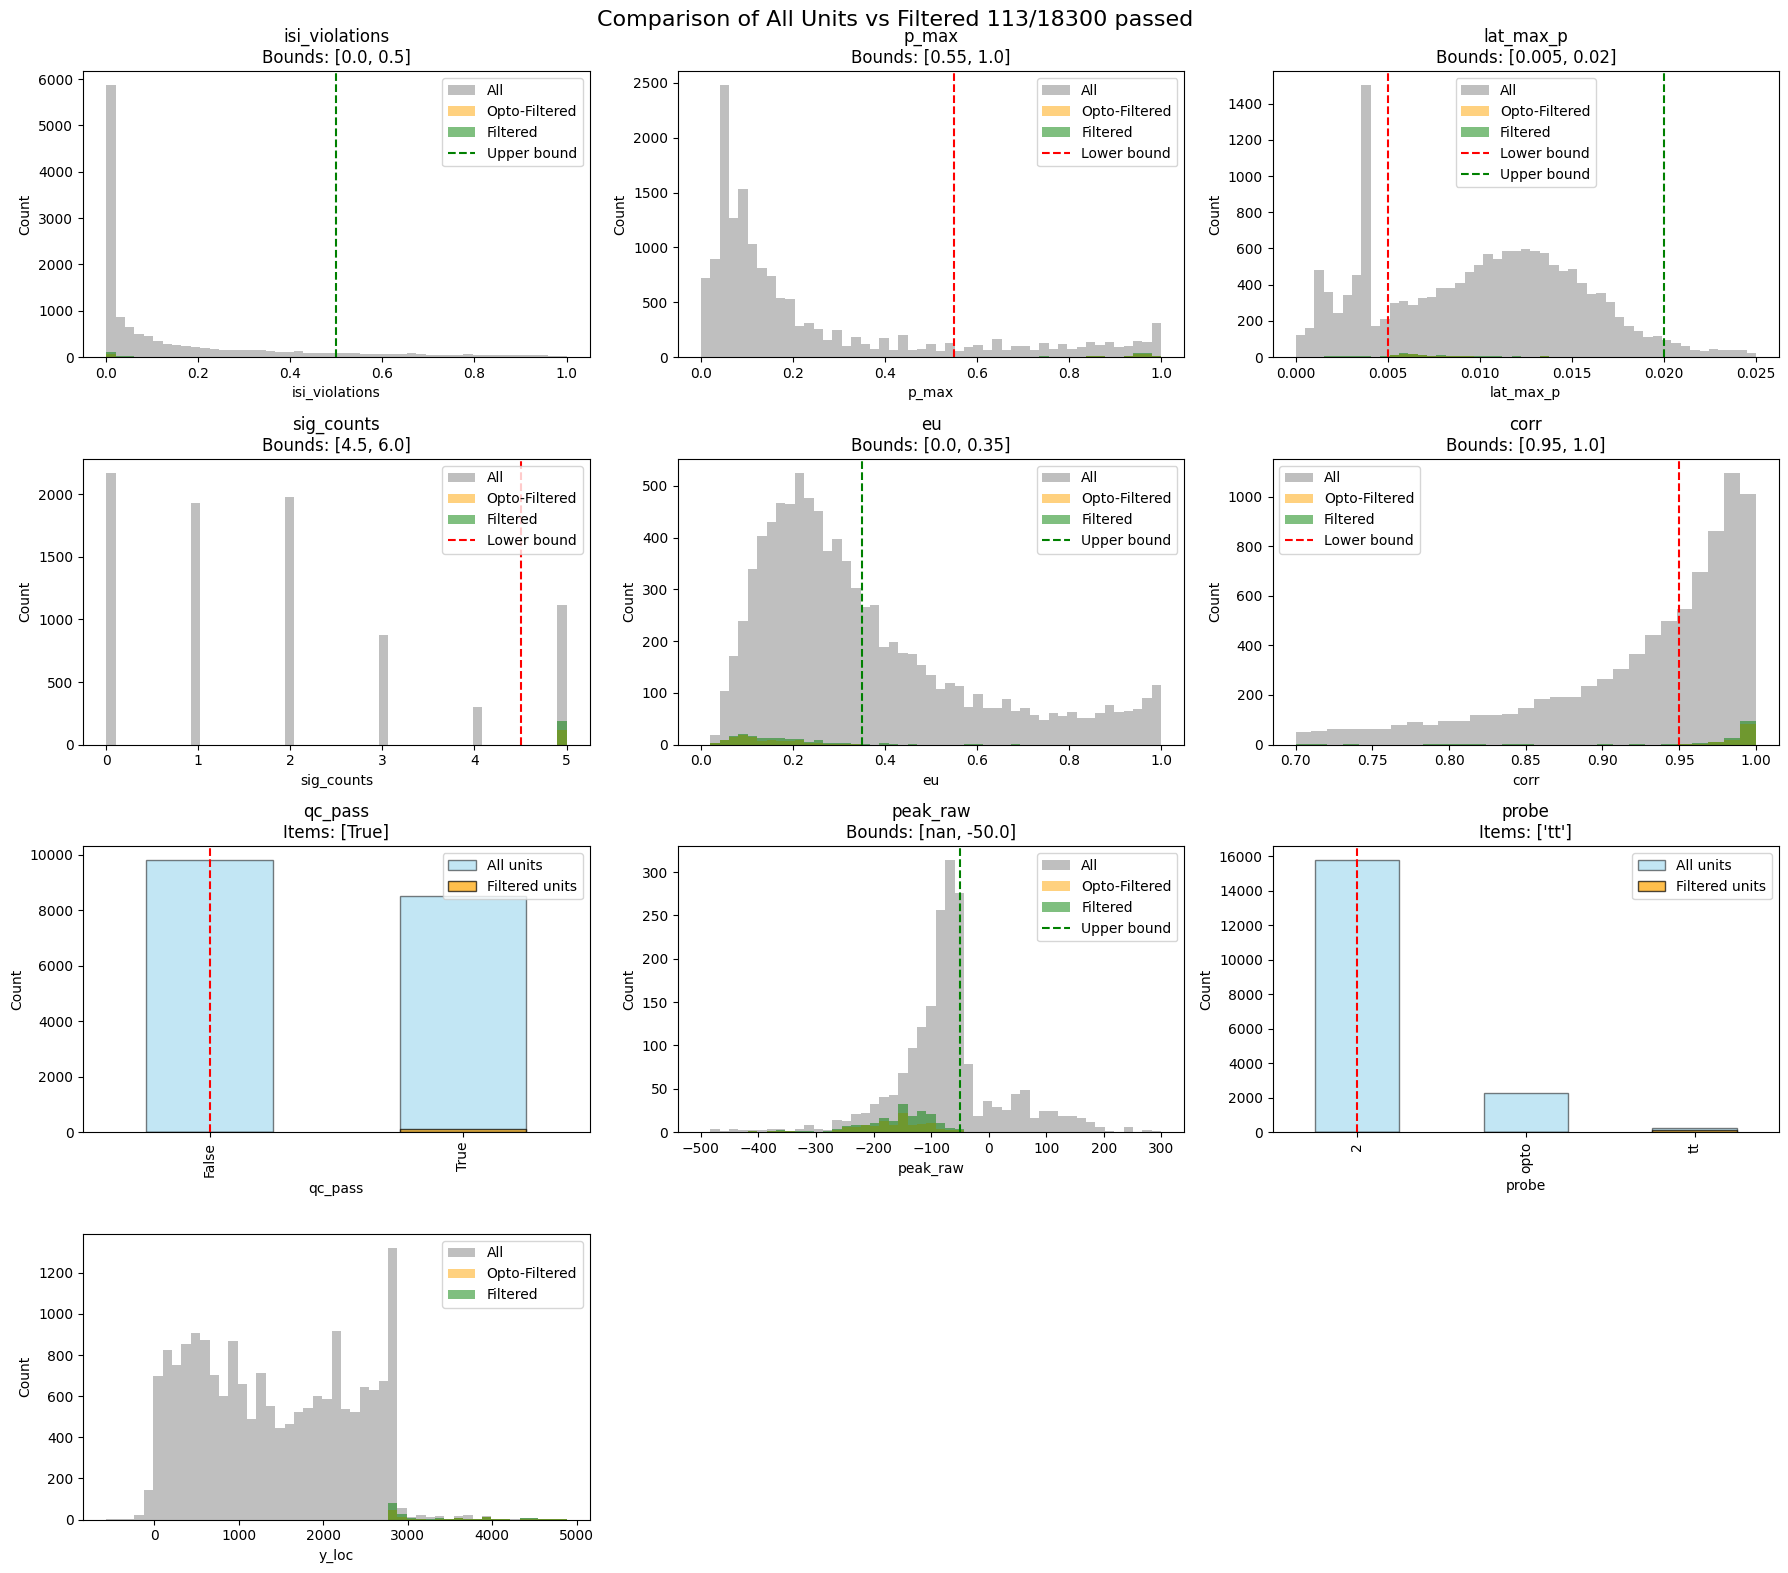

In [5]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints, density=False)
fig.savefig(os.path.join(target_folder, f'quality_metrics_combined_units_{criteria_name}_waveformQC.pdf'), dpi=300)

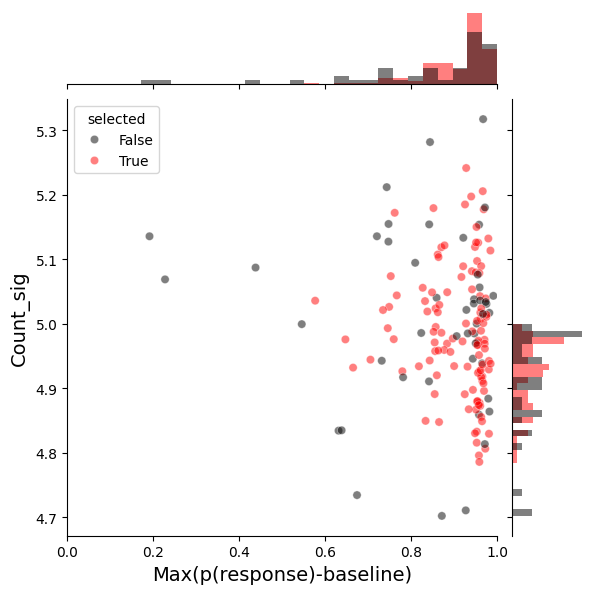

In [6]:
# opto tagged vs not
# Define color palette for groups
palette = {True: "r", False: "k"}
x_col = 'p_max'
y_col = 'sig_counts'

combined_tagged_units_plot = combined_tagged_units.copy()
combined_tagged_units_plot[y_col] = combined_tagged_units_plot[y_col]  + np.random.normal(0, 0.1, size=len(combined_tagged_units_plot[y_col]))  # add jitter to y-axis for better visibility

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units_plot[combined_tagged_units['selected_qc_only']], x=x_col, y=y_col, hue='selected', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Count_sig', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(0, 1, 30)
y_bins = np.linspace(combined_tagged_units_plot[combined_tagged_units['selected_qc_only']][y_col].min(), combined_tagged_units[combined_tagged_units['selected_qc_only']][y_col].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units_plot[combined_tagged_units['selected_qc_only'] & (combined_tagged_units['selected'] == qc_val)]
    # Horizontal histogram for x-axis (default orientation)
    ax = g.ax_marg_x
    ax.hist(subset[x_col], bins=p_max_bins, color=color, alpha=0.5, edgecolor='none', density='True')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    ax = g.ax_marg_y
    ax.hist(subset[y_col], bins=y_bins, color=color, alpha=0.5, edgecolor='none', density='True',  orientation='horizontal')
    # sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')

plt.savefig(os.path.join(target_folder, f'opto_pass_{x_col}_{y_col}_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
# Show plot
plt.show()



In [7]:
def zero_crossings_linear(x, y):
    """
    Find x positions where y crosses zero using linear interpolation.

    Parameters
    ----------
    x, y : 1D arrays of same length

    Returns
    -------
    x0 : 1D array
        x positions of zero crossings
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if x.ndim != 1 or y.ndim != 1 or len(x) != len(y):
        raise ValueError("x and y must be 1D arrays of the same length")

    # Find sign changes (exclude exact zeros handled below)
    sign_change = (y[:-1] * y[1:] < 0)

    x0 = x[:-1][sign_change] - y[:-1][sign_change] * (
        x[1:][sign_change] - x[:-1][sign_change]
    ) / (
        y[1:][sign_change] - y[:-1][sign_change]
    )

    # Handle exact zeros (y == 0)
    exact = np.where(y == 0)[0]
    if exact.size > 0:
        x0 = np.sort(np.concatenate([x0, x[exact]]))

    return x0


In [8]:
# Extract waveform feature
wf_norm = []
wf_2D_norm = []

half_w = []
trough_w = []
pre_half = []
post_half = []
post_w = []

trough_post_ratio_1D = []
trough_pre_ratio_1D = []

post_slope = []
post_space = []
pre_slope = []
pre_space = []

symmetry_inte = []
symmetry_half = []
symmetry_slope = []
symmetry_inte_div = []
symmetry_half_div = []
symmetry_slope_div = []


# wf_norm = combined_tagged_units_filtered['wf']/np.abs(combined_tagged_units_filtered['peak'])
# wf_2D_norm = combined_tagged_units_filtered['wf_2d']/np.abs(combined_tagged_units_filtered['peak'])

wf_norm = combined_tagged_units_filtered[f'wf{waveform_version}']/np.abs(combined_tagged_units_filtered[f'peak{waveform_version}'])
# wf_2D_norm = combined_tagged_units_filtered['wf_2d']/np.abs(combined_tagged_units_filtered['peak'])
for rows in combined_tagged_units_filtered.iterrows():
    print(f'Processing unit {rows[1]["unit"]} of session {rows[1]["session"]}')
    # wf = rows[1]['wf']
    # peak = rows[1]['peak']
    # print(rows[1]['session'])
    # print(rows[1]['unit'])
    if rows[0]==109:
        print(rows[0])
    wf = rows[1][f'wf{waveform_version}'][:32*5]
    wf_bl = np.nanmean(wf[:5])
    peak = rows[1][f'peak{waveform_version}'] - wf_bl
    wf = wf - wf_bl
    peak_ind = np.argmin(wf)

    if np.abs(wf[0]-wf[-1])>50:
        half_w.append(np.nan)  # half width in samples
        trough_w.append(np.nan)  # trough width in samples
        post_w.append(np.nan)  # post trough width in samples
        pre_half.append(np.nan)
        post_half.append(np.nan)
        trough_post_ratio_1D.append(np.nan)
        trough_pre_ratio_1D.append(np.nan)
        post_slope.append(np.nan)
        post_space.append(np.nan)
        pre_slope.append(np.nan)
        pre_space.append(np.nan)
        symmetry_inte.append(np.nan)
        symmetry_half.append(np.nan)
        symmetry_slope.append(np.nan)
        symmetry_inte_div.append(np.nan)
        symmetry_half_div.append(np.nan)
        symmetry_slope_div.append(np.nan)
        continue

    if peak<0:
        curr_trough_loc = np.argmax(wf[peak_ind:])+1
        post_trough = np.max(wf[peak_ind:])
        post_trough_ind = np.argmax(wf[peak_ind:])+1
        pre_trough = np.max(wf[:peak_ind])
        pre_trough_ind = peak_ind - np.argmax(wf[:peak_ind])  
    else:
        curr_trough_loc = np.argmin(wf[peak_ind:])+1
        post_trough = np.min(wf[peak_ind:])
        post_trough_ind = np.argmin(wf[peak_ind:])+1
        pre_trough = np.min(wf[:peak_ind])
        pre_trough_ind = peak_ind - np.argmin(wf[:peak_ind])  
    curr_trough_post = post_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_pre = pre_trough/peak # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_post = (post_trough/peak)/post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_post = ((peak - pre_trough)/peak)*post_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_slope_pre = ((peak - pre_trough)/peak)/pre_trough_ind # positive if same sign, negative if opposite sign
    curr_trough_loc_inte_pre = ((peak - post_trough)/peak)*pre_trough_ind # positive if same sign, negative if opposite sign

    curr_symmetry_inte = curr_trough_loc_inte_post - curr_trough_loc_inte_pre  # positive if same sign, negative if opposite sign
    curr_symmetry_slope = curr_trough_loc_slope_post - curr_trough_loc_slope_pre  # positive if same sign, negative if opposite sign
    
    

    # find samples where the waveform crosses the half peak threshold to infer half width
    half_peak = peak / 2
    # wf_half_crossings = np.where(np.diff(np.sign(wf - half_peak))!=0)[0]+1  # indices where waveform crosses half peak
    wf_half_crossings = zero_crossings_linear(np.arange(len(wf)), wf - half_peak)
    if len(wf_half_crossings) < 2:
        post_crossing = np.nan
        pre_crossing = np.nan
    else: 
        if np.all(wf_half_crossings < peak_ind) or np.all(wf_half_crossings > peak_ind):
            post_crossing = np.nan
            pre_crossing = np.nan
        else:
            post_crossing = np.min(wf_half_crossings[wf_half_crossings > peak_ind]) - peak_ind
            pre_crossing = peak_ind - np.max(wf_half_crossings[wf_half_crossings < peak_ind])

    half_w.append(post_crossing + pre_crossing)  # half width in samples
    trough_w.append(post_trough_ind + pre_trough_ind)  # trough width in samples
    post_w.append(post_trough_ind)  # post trough width in samples
    pre_half.append(pre_crossing)
    post_half.append(post_crossing)

    trough_post_ratio_1D.append(curr_trough_post)
    trough_pre_ratio_1D.append(curr_trough_pre)

    post_slope.append(curr_trough_loc_slope_post)
    post_space.append(curr_trough_loc_inte_post)
    pre_slope.append(curr_trough_loc_slope_pre)
    pre_space.append(curr_trough_loc_inte_pre)

    symmetry_inte.append(curr_trough_loc_inte_post - curr_trough_loc_inte_pre)
    symmetry_half.append(post_crossing - pre_crossing)
    symmetry_slope.append(curr_trough_loc_slope_post - curr_trough_loc_slope_pre)

    symmetry_inte_div.append(curr_trough_loc_inte_post/curr_trough_loc_inte_pre)
    symmetry_half_div.append(post_crossing/pre_crossing)
    symmetry_slope_div.append(curr_trough_loc_slope_post/curr_trough_loc_slope_pre)


wf_features = pd.DataFrame({'unit_id': combined_tagged_units_filtered['unit'],
                            'session': combined_tagged_units_filtered['session'],
                            'amp': combined_tagged_units_filtered['amp'],
                            'peak': combined_tagged_units_filtered['peak'],
                            'half_w': half_w,
                            'trough_w': trough_w,
                            'pre_half': pre_half,
                            'post_half': post_half,
                            'post_w': post_w,
                            'trough_post_ratio_1D': trough_post_ratio_1D,
                            'trough_pre_ratio_1D': trough_pre_ratio_1D,
                            'post_slope': post_slope,
                            'post_space': post_space,
                            'pre_slope': pre_slope,
                            'pre_space': pre_space,
                            'symmetry_inte': symmetry_inte,
                            'symmetry_half': symmetry_half,
                            'symmetry_slope': symmetry_slope,
                            'symmetry_inte_div': symmetry_inte_div,
                            'symmetry_half_div': symmetry_half_div,
                            'symmetry_slope_div': symmetry_slope_div,
                            'y_loc': combined_tagged_units_filtered['y_loc'],
                            'probe': combined_tagged_units_filtered['probe'],
                            })
wf_features['symmetry_inte_div_log'] = np.log(wf_features['symmetry_inte_div'])
wf_features['symmetry_slope_div_log'] = np.log(-wf_features['symmetry_slope_div'] + 1e-6)
wf_features.rename(columns={'unit_id': 'unit'}, inplace=True)
                            


Processing unit TT4_SS_02 of session behavior_ZS059_2021-03-28_14-18-58
Processing unit TT4_SS_01 of session behavior_ZS059_2021-03-29_14-41-57
Processing unit TT4_SS_01 of session behavior_ZS059_2021-03-30_14-57-13
Processing unit TT4_SS_02 of session behavior_ZS059_2021-03-31_14-32-51
Processing unit TT4_SS_01 of session behavior_ZS059_2021-04-01_14-17-46
Processing unit TT4_SS_01 of session behavior_ZS059_2021-04-10_15-55-11
Processing unit TT4_SS_01 of session behavior_ZS059_2021-04-15_15-29-28
Processing unit TT4_SS_01 of session behavior_ZS059_2021-04-21_15-58-55
Processing unit TT4_SS_02 of session behavior_ZS059_2021-04-22_15-11-25
Processing unit TT3_SS_01 of session behavior_ZS061_2021-03-20_18-03-26
Processing unit TT4_SS_01 of session behavior_ZS061_2021-03-20_18-03-26
Processing unit TT3_SS_03 of session behavior_ZS061_2021-03-22_17-35-53
Processing unit TT4_SS_01 of session behavior_ZS061_2021-03-22_17-35-53
Processing unit TT1_SS_02 of session behavior_ZS061_2021-03-23_1

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


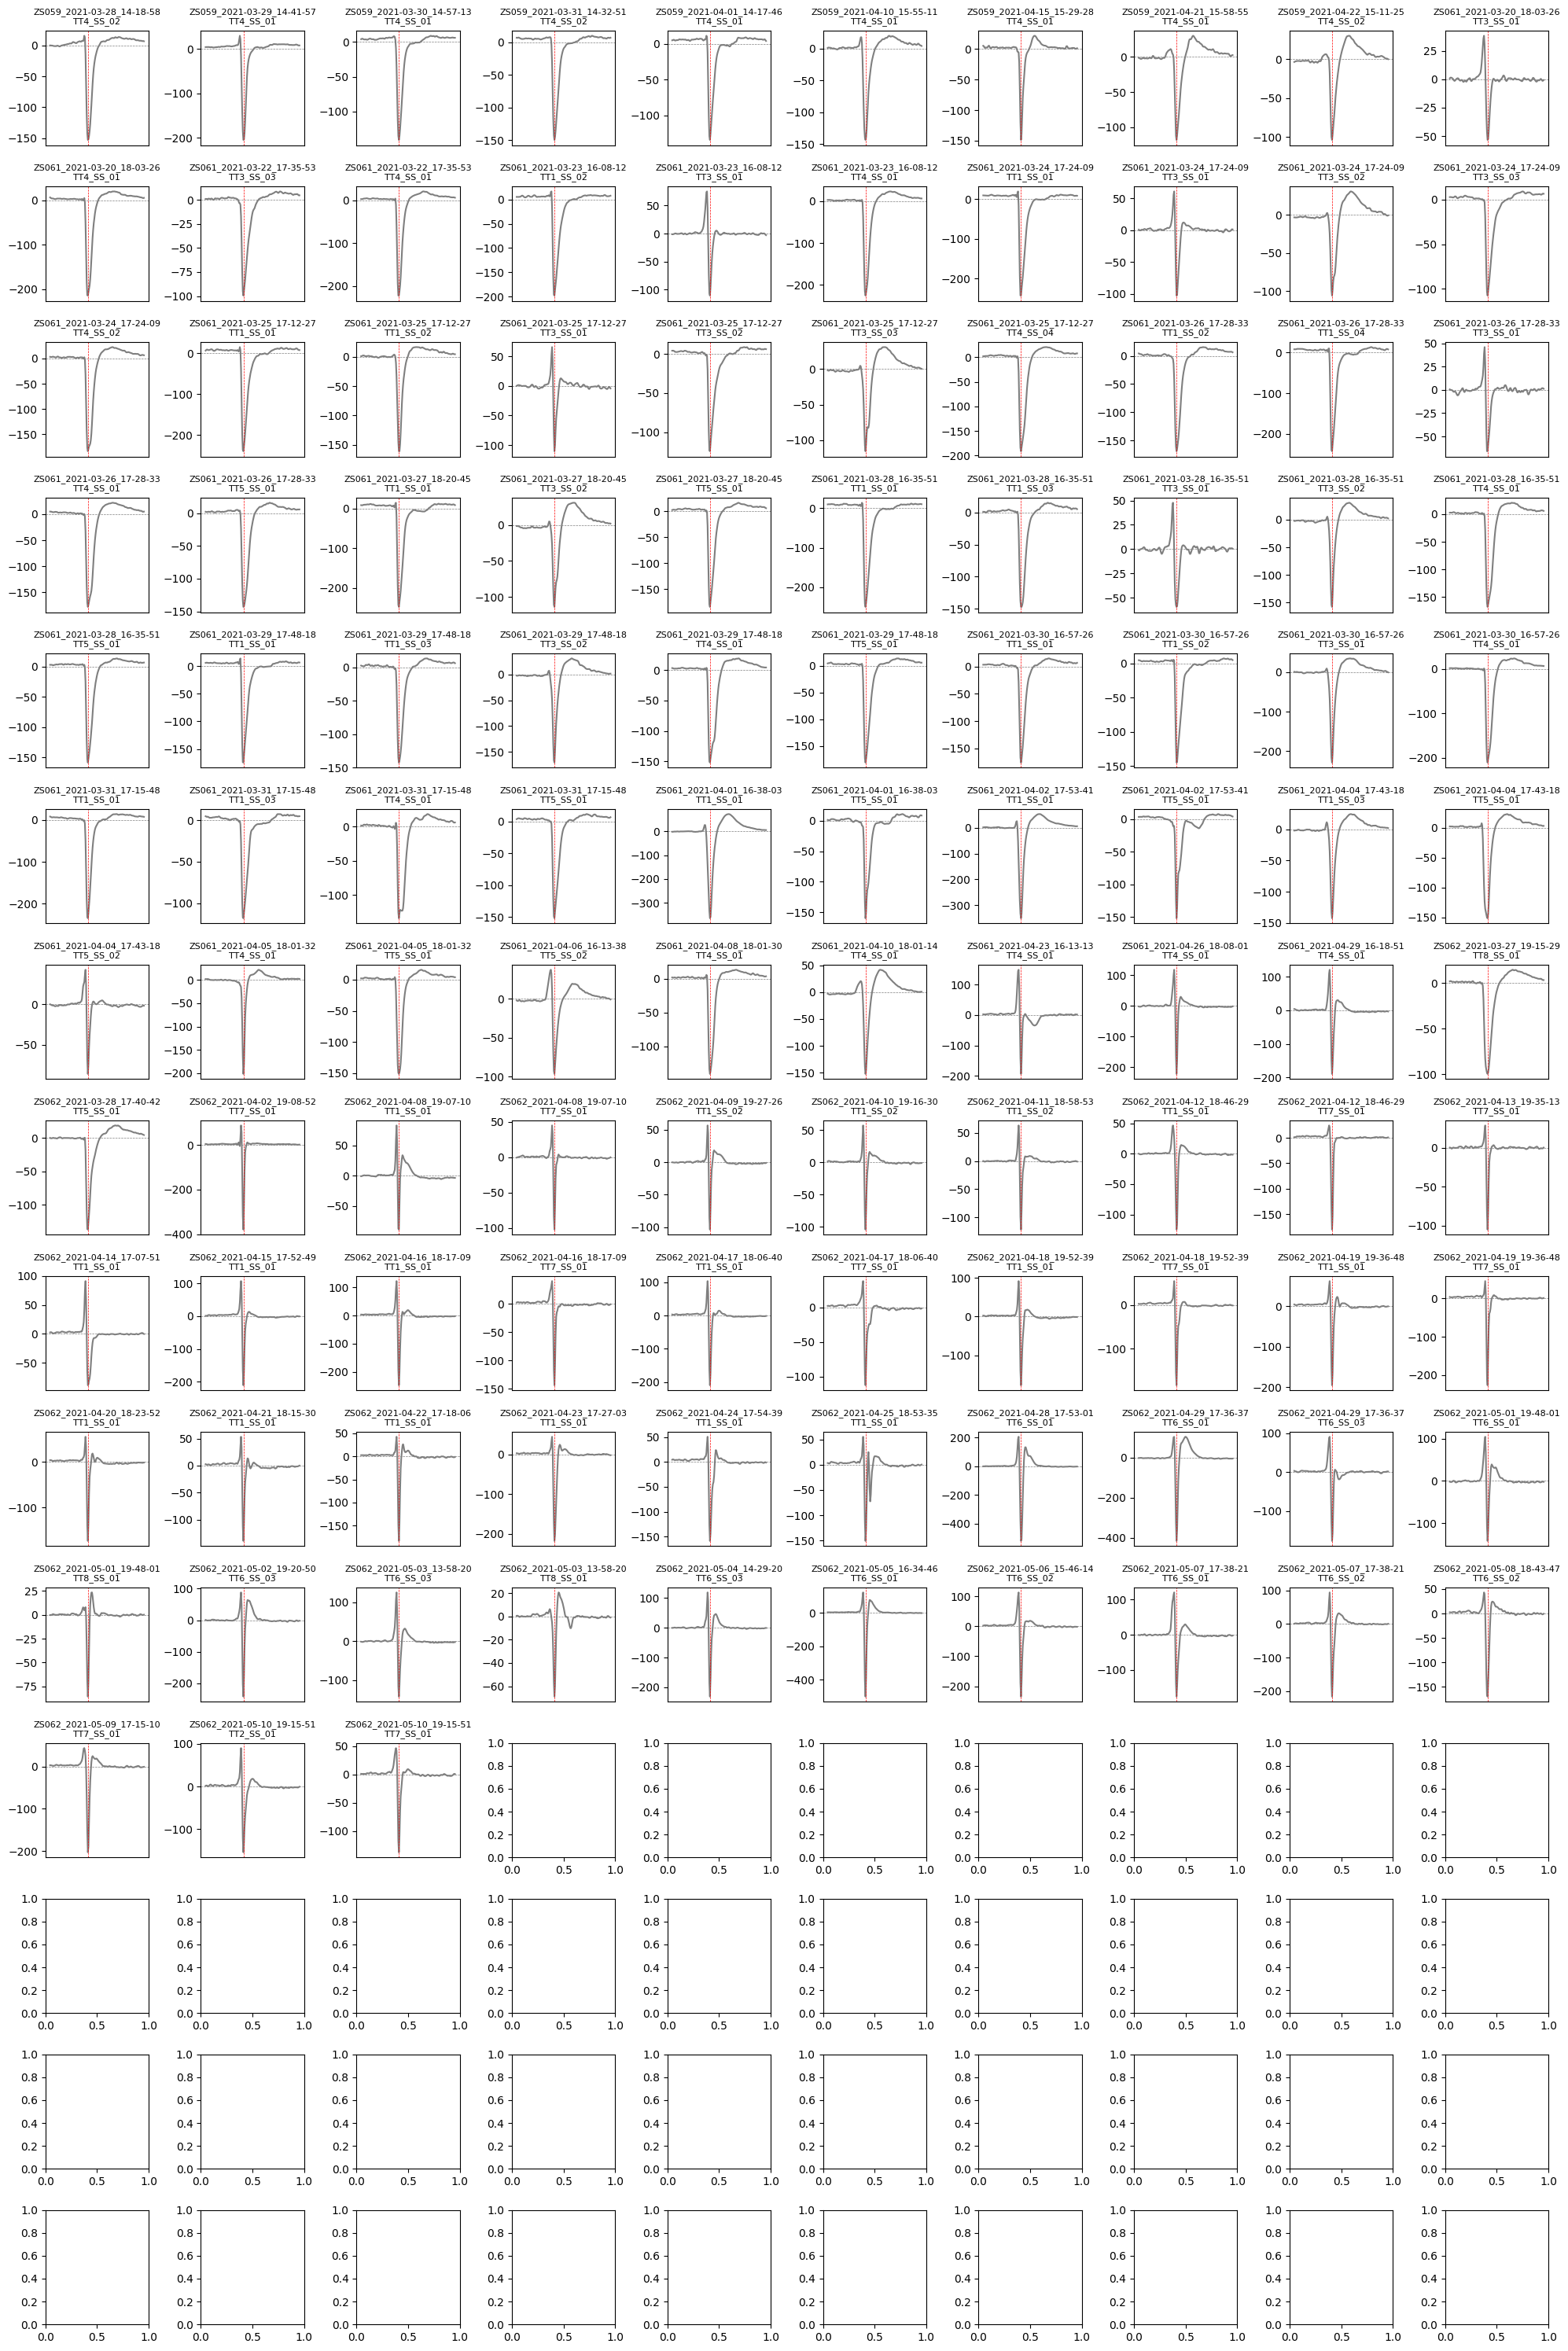

In [9]:
# plot all waveforms with session and unit id
fig, axs = plt.subplots(nrows=15, ncols=10, figsize=(20, 30))
for i, rows in enumerate(combined_tagged_units_filtered.iterrows()):
    ax = axs[i//10, i%10]
    wf = rows[1][f'wf{waveform_version}'][:32*5]
    # wf_bl = np.nanmean(wf[:5])
    # wf = wf - wf_bl
    peak = rows[1][f'peak{waveform_version}'] - wf_bl
    peak_ind = np.argmin(wf)
    ax.plot(wf, color='k', alpha=0.5)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.axvline(peak_ind, color='r', linestyle='--', linewidth=0.5)
    ax.set_title(f'{rows[1]["session"][9:]}\n{rows[1]["unit"]}', fontsize=8)
    ax.set_xticks([])
    # ax.set_yticks([])
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'all_waveforms_{criteria_name}_waveformQC.pdf'), dpi=300)

In [10]:
wf_list = combined_tagged_units_filtered[f'wf{waveform_version}'].values
peak_list = combined_tagged_units_filtered[f'peak{waveform_version}'].values

# Stack waveforms into 2D array (n_units x n_timepoints)
wf_array = np.vstack(wf_list)
wf_array = wf_array[:, :32*5]  # ensure consistent length

# Normalize each row by corresponding peak value
wf_norm = wf_array / peak_list[:, np.newaxis]  # shape: (n_units, n_timepoints)


In [11]:
# g = sns.pairplot(wf_features, corner=False, 
#              plot_kws={'alpha': 0.5, 's': 10},
#             #  hue='probe'
#              )
# # save figure
# # title = f"{len(wf_features)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak']['bounds'][1]} uV"
# # g.fig.suptitle(title, y=1.02)
# g.savefig(os.path.join(wf_folder, f'Wf_features_pairplot_{criteria_name}.png'), dpi=300)

In [12]:
# ncols = 8
# nrows = int(np.ceil(len(combined_tagged_units_filtered) / ncols))
# features = ['amp', 'peak', 'trough_post_ratio_1D', 'fall_slope', 'fall_space', 'symmetry']
# for feature in features:
#     if feature not in combined_tagged_units_filtered.columns:
#         continue
#     focus = combined_tagged_units_filtered[feature].values
#     resorted = combined_tagged_units_filtered.sort_values(by=feature, ascending=False).reset_index(drop=True)
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 2*nrows))
#     for i, row in resorted.iterrows():
#         ax = axes[i // ncols, i % ncols]
#         wf = row['wf']
#         peak = row['peak']
#         ax.plot(wf/np.abs(peak), color='blue')
#         # remove x and y axis
#         ax.axis('off')
#         ax.set_title(f'{row[feature]:.2f}')
#     plt.suptitle(feature, fontsize=16)
#     plt.tight_layout()
#     fig.savefig(fname=os.path.join(wf_folder, f'{feature}_wf.png'), dpi=300, bbox_inches='tight')

In [13]:
# cell_ind =25
# time = (np.arange(90)-30)*(1000/30000)
# plt.plot(time, -wf_norm[cell_ind], linewidth=7, color='k')
# plt.xlabel('Time (ms)')
# plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
# plt.xlim()
# # 
# ind = np.argmin(np.abs(wf_norm[cell_ind][30:]+trough_post_ratio_1D[cell_ind])) + 30
# # plt.axhline(trough_post_ratio_1D[cell_ind], color='r', linestyle='--', linewidth=5)
# plt.plot([time[ind], time[ind]], [0, trough_post_ratio_1D[cell_ind]], color='r', linewidth=5)
# # plt.scatter(ind[0]*(1000/30000), trough_post_ratio_1D[0])
# # turn off box
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.savefig(os.path.join(wf_folder, f'{cell_ind}_wf_AHP.pdf'), dpi=300, bbox_inches='tight')


In [14]:
# grab all tagged units and combine spike waveforms
all_wfs = combined_tagged_units_filtered[f'wf{waveform_version}'].tolist()
# all_wfs_aligned = combined_tagged_units_filtered['wf_aligned'].tolist()
all_peaks = combined_tagged_units_filtered[f'peak{waveform_version}'].tolist()
all_wfs = np.array(all_wfs)[:, :32*5]
# all_wfs_aligned = np.array(all_wfs_aligned)
baseline = np.mean(all_wfs[:, :3], axis=1, keepdims=True) 
peaks = np.array(all_peaks).reshape(-1, 1) 

all_wfs_nl = (all_wfs - baseline) / ((np.squeeze(all_wfs[:, 64]) - np.squeeze(baseline))[:, np.newaxis])
all_wfs_nl_raw = all_wfs/all_wfs[:,64][:, np.newaxis]
all_wfs_nl[all_wfs_nl_raw[:, 0]>1, :] = np.nan  # remove bad waveforms
# all_wfs_aligned_nl = all_wfs_aligned/all_wfs_aligned[:,30].reshape(-1, 1)
all_wfs_nl_clean = all_wfs_nl[~np.isnan(all_wfs_nl[:,0])]


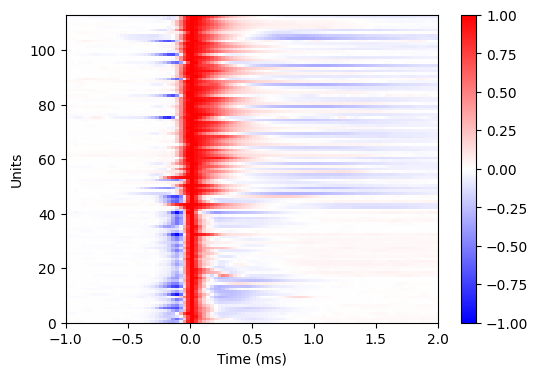

In [15]:
fig = plt.figure(figsize=(6, 4))
amp_max = np.max(np.abs(all_wfs_nl))
plt.imshow(all_wfs_nl, aspect='auto', cmap='bwr', extent=[-2, 3, 0, all_wfs_nl.shape[0]], vmax=1, vmin=-1, interpolation='None')
plt.colorbar()
plt.xlim(-1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Units')

plt.savefig(os.path.join(target_folder, f'all_waveforms_heatmap.pdf'), dpi=300, bbox_inches='tight')


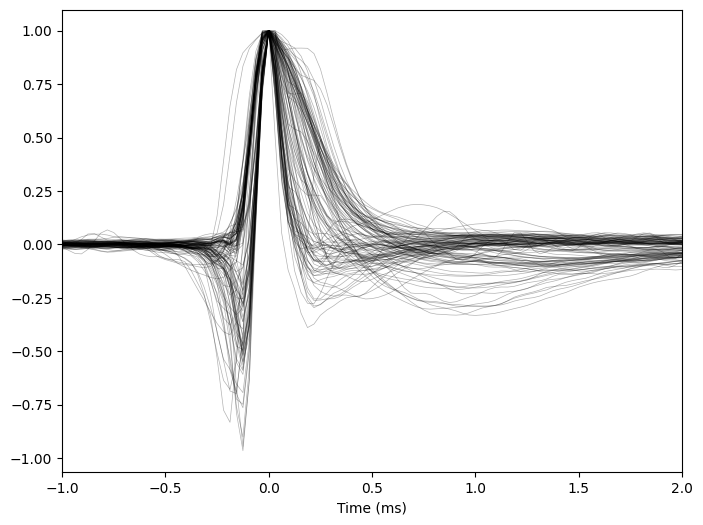

In [16]:
time = (np.arange(0, np.shape(all_wfs_nl_clean)[1])-64)/32
fig = plt.figure(figsize=(8, 6))
plt.plot(time, all_wfs_nl_clean.T, 'k', linewidth=0.5, alpha=0.3);
plt.xlabel('Time (ms)')
plt.xlim(-1, 2)
fig.savefig(os.path.join(target_folder, f'all_waveforms_overlay.pdf'), dpi=300, bbox_inches='tight')

In [17]:
# fig = plt.figure(figsize=(24, 24))
# gs = gridspec.GridSpec(int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), int(np.ceil(np.sqrt(len(all_wfs_nl_clean)))), figure=fig)
# for i in range(len(all_wfs_nl_clean)):
#     ax = fig.add_subplot(gs[i])
#     plt.plot(pc_time, all_wfs_pc[i], alpha=0.7, color='k', linewidth=1);
#     plt.plot(pc_time, all_wfs_nl_clean[i], color='r', alpha=0.5, linestyle='--', linewidth=1)
#     # turn off the axis
#     ax.set_xticks([])
#     ax.set_yticks([])
#     for spine in ax.spines.values():
#         spine.set_visible(False)    
# title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak_raw']['bounds'][1]} uV"
# plt.suptitle(title, fontsize=16)
# plt.savefig(fname=os.path.join(wf_folder, f'All-wf_{criteria_name}.pdf'))


In [18]:
# perform PCA
wf_mat = zscore(all_wfs_nl_clean, axis=0).copy()
wf_mat = np.delete(wf_mat, 64, axis=1)  # remove the peak sample to avoid error in PCA
# wf_mat = wf_mat[:, 2:-2]
# wf_mat = zscore(all_wfs_nl_clean, axis=0)  # z-score normalize the waveforms
# wf_mat = np.delete(wf_mat, 20, axis=1)  # remove the peak sample to avoid bias in PCA
pca = PCA(n_components=5)  # we can choose the number of components we want
pca_result = pca.fit_transform(wf_mat)
explained_variance = pca.explained_variance_ratio_


/tmp/ipykernel_2823713/5002745.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  wf_mat = zscore(all_wfs_nl_clean, axis=0).copy()


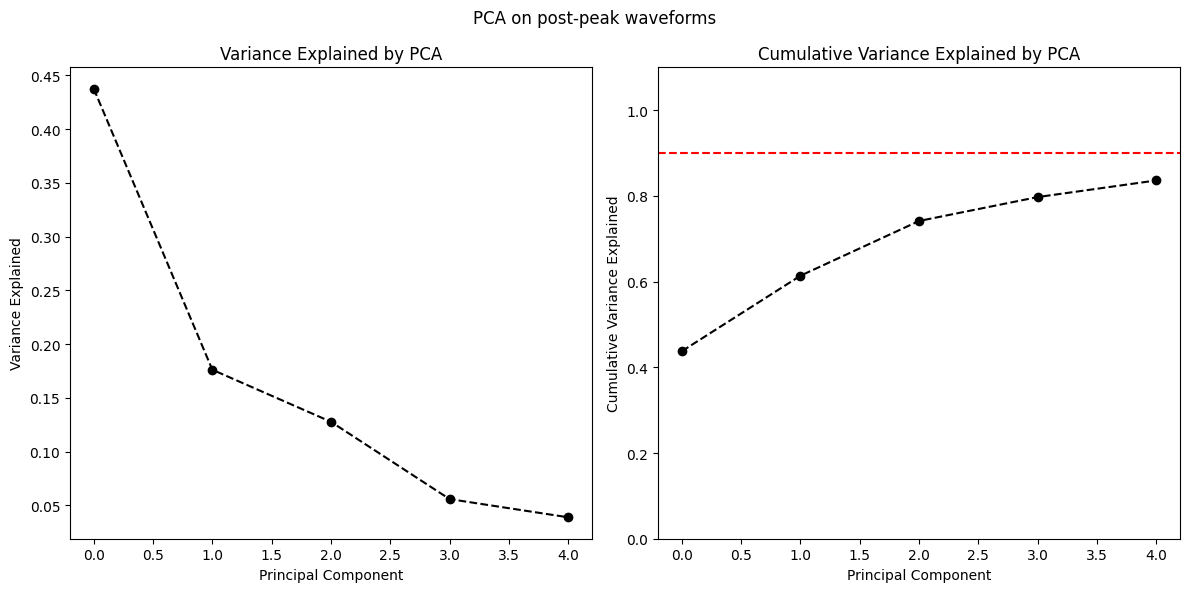

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(pca.explained_variance_ratio_, marker='o', linestyle='--', color='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Variance Explained by PCA')
axes[1].plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='black')
axes[1].axhline(0.9, color='red', linestyle='--', label='90% Variance')
axes[1].set_ylim(0, 1.1)
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained by PCA')
plt.suptitle('PCA on post-peak waveforms')
plt.tight_layout()

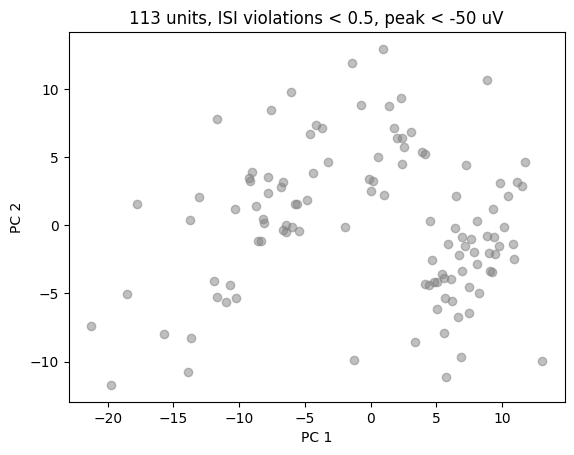

In [20]:
# score = 0.2*pca_result[:, 0] + pca_result[:, 1]
# score = pca_result[:, 0]
score = pca_result[:, 0]
# score = pca_result[:, 0] + pca_result[:, 2]
filter = score > 20
pc1 = 0
pc2 = 1
plt.scatter(pca_result[filter, pc1], pca_result[filter, pc2], c = 'k', alpha=0.7)
plt.scatter(pca_result[~filter, pc1], pca_result[~filter, pc2], c = 'gray', alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak_raw']['bounds'][1]} uV"
plt.title(title)
plt.savefig(fname=os.path.join(wf_folder, f'pca_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

In [21]:
# kmeans clustering in PC1
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


focus_pcs = pca_result[:, 0:2]
# focus_pcs = focus_pcs.reshape(-1, 1)

# Perform KMeans clustering (e.g., into 2 clusters)
# loop through random states 0 to 50 and pick best separation in kmeans
inertias = []
sil_scores = []
for random_state in range(50):
    kmeans = KMeans(n_clusters=2, random_state=random_state)
    clusters = kmeans.fit_predict(focus_pcs)
    inertia = kmeans.inertia_
    sil_score = silhouette_score(focus_pcs, clusters)
    inertias.append(inertia)
    sil_scores.append(sil_score)

rand_ind_max = np.argmin(np.array(inertias))
rand_ind_max = np.argmax(np.array(sil_scores))
print(f'inter {np.min(np.array(inertias))}')
print(f'sil {np.max(np.array(sil_scores))}')
kmeans = KMeans(n_clusters=2, random_state=rand_ind_max)
clusters = kmeans.fit_predict(focus_pcs)
print(f'Best random state: {rand_ind_max}')
print(f'Intertia: {kmeans.inertia_}')
print(f'Silhouette score: {silhouette_score(focus_pcs, clusters)}')

inter 4871.425640602315
sil 0.5078456775713492
Best random state: 1
Intertia: 4871.425640602315
Silhouette score: 0.5078456775713492


In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np

focus_pcs = pca_result[:, 0:2]
# focus_pcs = pca_result[:, 0:2].reshape(-1, 1)

log_likelihoods = []
sil_scores = []

for random_state in range(100):
    gmm = GaussianMixture(n_components=2, random_state=random_state, covariance_type='full')
    gmm.fit(focus_pcs)
    clusters = gmm.predict(focus_pcs)
    log_likelihoods.append(gmm.score(focus_pcs) * len(focus_pcs))  # total log-likelihood
    sil_scores.append(silhouette_score(focus_pcs, clusters))

# Use silhouette to select best
best_seed = np.argmax(sil_scores)
print(f'Best seed: {best_seed}')
print(f'Log-likelihood: {log_likelihoods[best_seed]}')
print(f'Silhouette score: {sil_scores[best_seed]}')

# Fit final model with best seed
gmm = GaussianMixture(n_components=2, random_state=best_seed, covariance_type='full')
gmm.fit(focus_pcs)
clusters = gmm.predict(focus_pcs)
mean1, mean2 = gmm.means_  # shape: (2, 2)

# Direction vector from one mean to the other
direction = mean2 - mean1
direction /= np.linalg.norm(direction)


Best seed: 0
Log-likelihood: -701.8277767819565
Silhouette score: 0.4824501127498231


[ 0.93731192 -0.34849155]


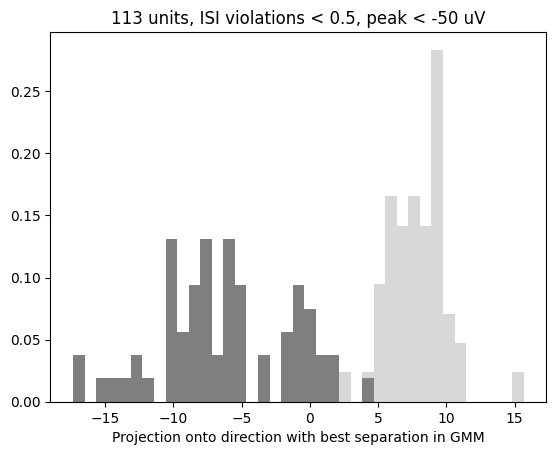

In [23]:
# clusters is a 1D array of cluster labels (0 or 1)
# score = direction[0] * focus_pcs[:, 0] + direction[1] * focus_pcs[:, 1]
score = np.dot(focus_pcs, direction)
bins = np.linspace(np.min(score), np.max(score), 40)
plt.hist(score[clusters==0], bins=bins, color='k', alpha=0.5, density=True);
plt.hist(score[clusters==1], bins=bins, color='gray', alpha=0.3, density=True);
plt.xlabel('Projection onto direction with best separation in GMM')
title = f"{len(all_wfs_nl_clean)} units, ISI violations < {constraints['isi_violations']['bounds'][1]}, peak < {constraints['peak_raw']['bounds'][1]} uV"
plt.title(title)
plt.savefig(fname=os.path.join(target_folder, f'GMM_Projection_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
print(direction)

In [24]:
y_loc = combined_tagged_units_filtered['y_loc'].values
animals = ['ZS059', 'ZS060', 'ZS061', 'ZS062']
for animal in animals:
    print(animal)
    ani_session_ind = combined_tagged_units_filtered['session'].str.contains(
                            animal,
                            regex=False,
                            na=False
                        )
    if np.sum(ani_session_ind)==0:
        continue
    y_loc[ani_session_ind] = y_loc[ani_session_ind]  - np.nanmin(y_loc[ani_session_ind])

ZS059
ZS060
ZS061
ZS062


In [25]:
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (0, 1, 1)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (1, 0, 0))])

In [26]:
# import rankdata
from scipy.stats import rankdata
y_loc_ranked = rankdata(y_loc)


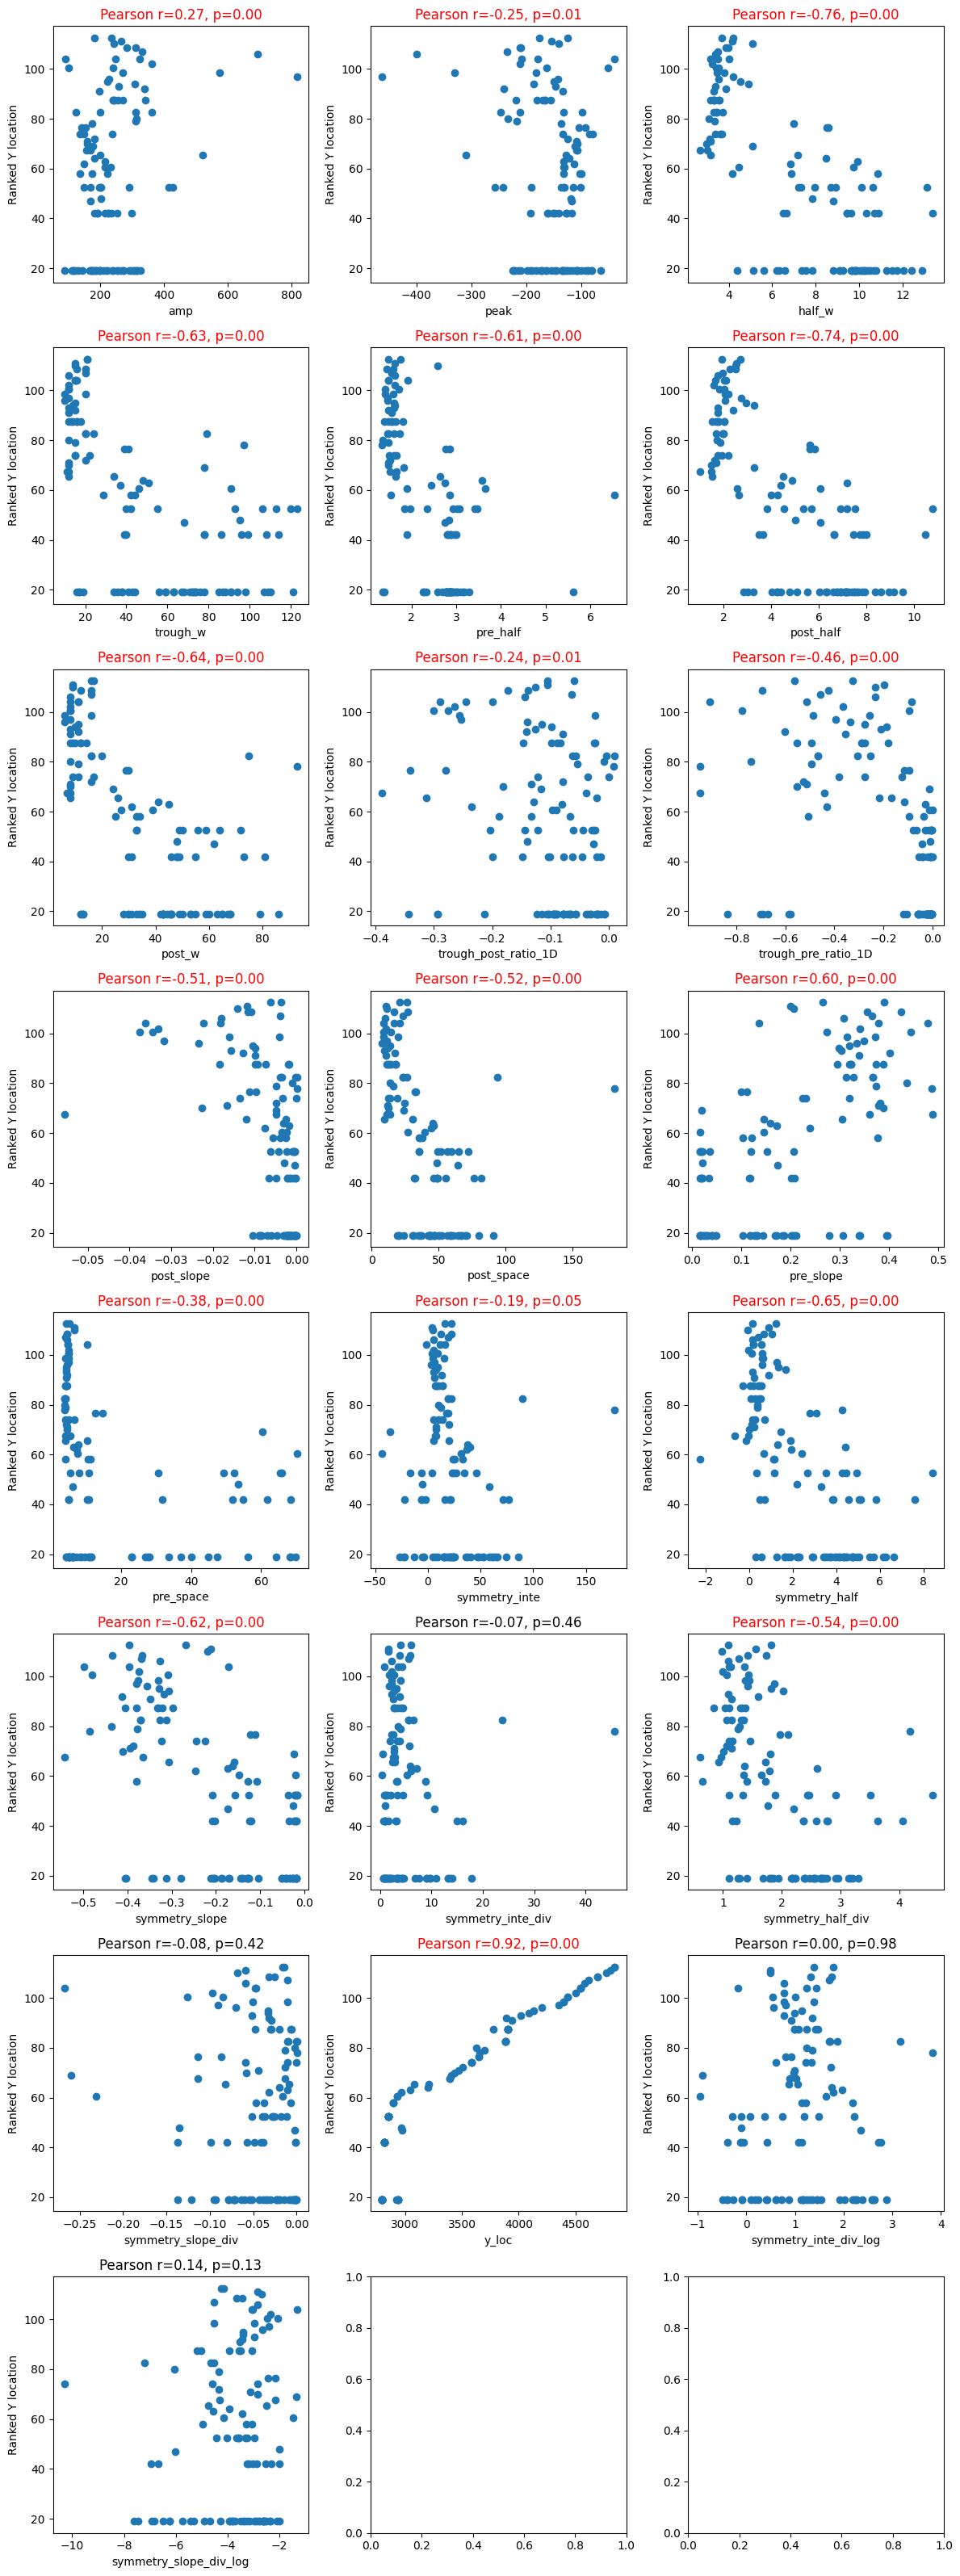

In [27]:
# scatter plot and correlation with ranked 
features = wf_features.columns.tolist()
features.remove('unit')
features.remove('session')
features.remove('probe')
n_rows = int(np.ceil(len(features)/3))
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(4*3, 4*n_rows))
for feature_ind, feature in enumerate(features):
    ax = axes[feature_ind // 3, feature_ind % 3]
    focus = wf_features[feature].values
    sc = ax.scatter(focus, y_loc_ranked)
    ax.set_xlabel(feature)
    ax.set_ylabel('Ranked Y location')
    # calculate pearson correlation
    valid_ind = ~np.isnan(focus)
    corr, pval = stats.pearsonr(focus[valid_ind], y_loc_ranked[valid_ind])
    if pval<=0.05:
        title_color = 'red'
    else:
        title_color = 'black'

    ax.set_title(f'Pearson r={corr:.2f}, p={pval:.2f}', color=title_color)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'Wf_features_vs_Yloc.pdf'), dpi=300, bbox_inches='tight')

In [28]:
# pca on focus features
focus_features = ['half_w', 'pre_half', 'post_w', 
                'trough_post_ratio_1D', 'post_slope', 'post_space', 
                'symmetry_slope', 'symmetry_slope_div_log', 'symmetry_inte_div', 'symmetry_inte_div_log',
                ]

/tmp/ipykernel_2823713/2209900535.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')
/tmp/ipykernel_2823713/2209900535.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')
/tmp/ipykernel_2823713/2209900535.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(focus_features, rotation=45, ha='right')


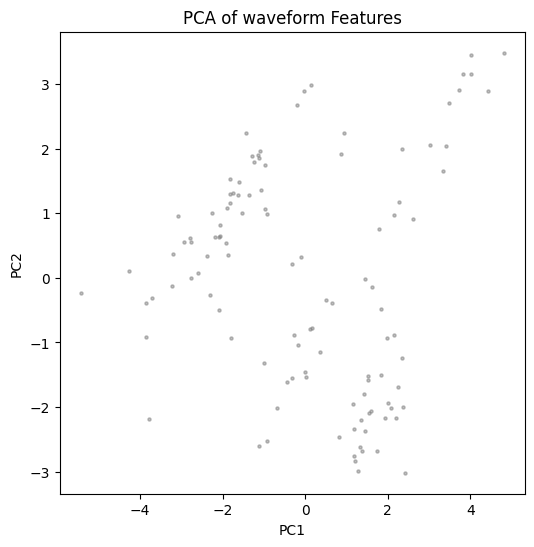

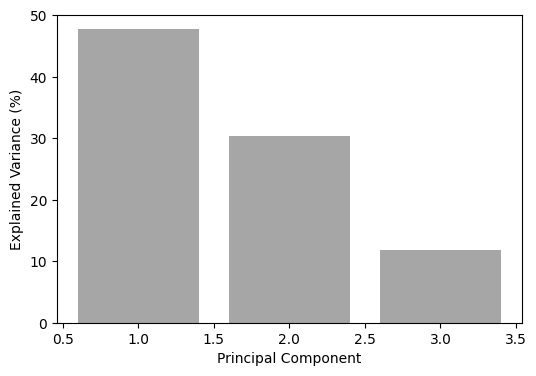

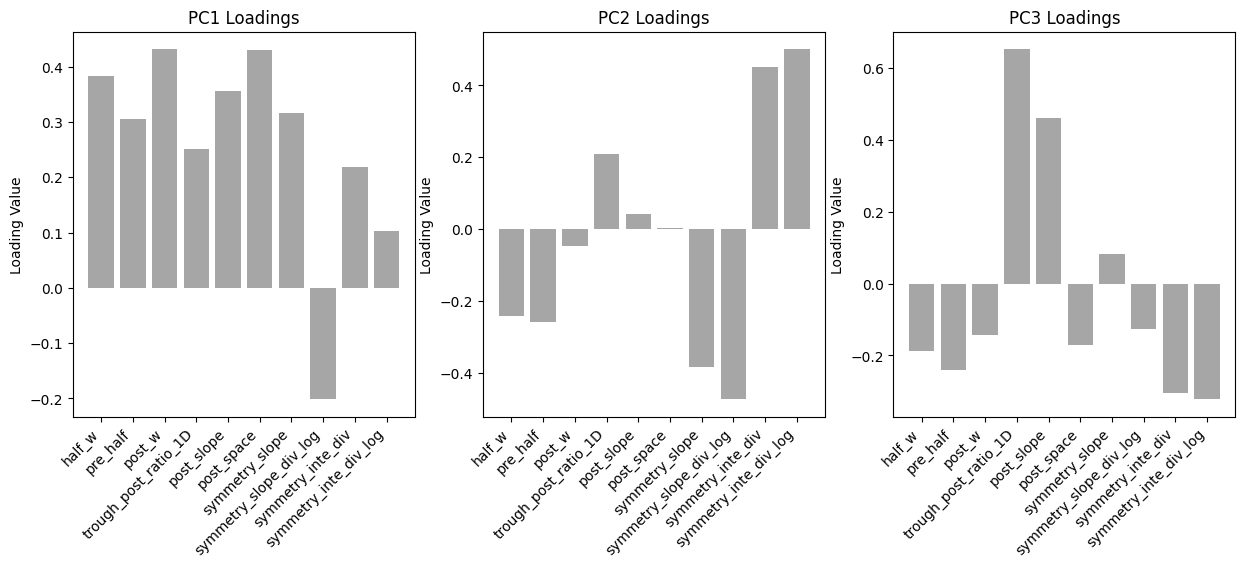

In [29]:
from sklearn.decomposition import PCA
feature_mat = wf_features[focus_features].values
# remove rows with nan
nan_ind = np.isnan(feature_mat).any(axis=1)
feature_mat = feature_mat[~nan_ind]
# zscore
from scipy.stats import zscore
feature_mat = zscore(feature_mat, axis=0, nan_policy='omit')

pca = PCA(n_components=3)
pca_result = pca.fit_transform(feature_mat)
# plot
fig = plt.figure(figsize=(6, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='gray', alpha=0.5, s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of waveform Features')
# plot explained variance ratio
explained_var = pca.explained_variance_ratio_
fig = plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_var)+1), explained_var*100, color='gray', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')

# plot how each features contribute to each PC, plot by PC
components = pca.components_
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    ax.bar(focus_features, components[i], color='gray', alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings')
    ax.set_ylabel('Loading Value')
    ax.set_xticklabels(focus_features, rotation=45, ha='right')

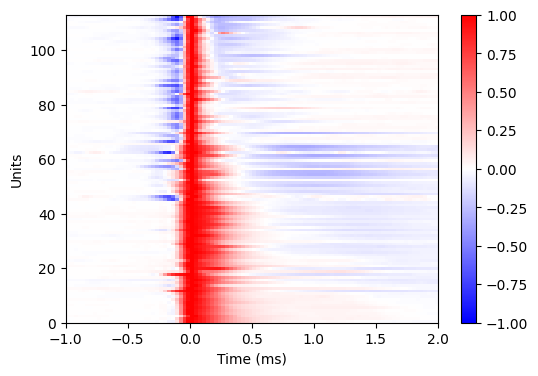

In [30]:
fig = plt.figure(figsize=(6, 4))
amp_max = np.max(np.abs(all_wfs_nl))
sort_ind = np.argsort(pca_result[:, 0])

plt.imshow(all_wfs_nl[~nan_ind,:][sort_ind], aspect='auto', cmap='bwr', extent=[-2, 3, 0, all_wfs_nl.shape[0]], vmax=1, vmin=-1, interpolation='None')
plt.colorbar()
plt.xlim(-1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Units')

plt.savefig(os.path.join(target_folder, f'all_waveforms_heatmap_pc1_sorted.pdf'), dpi=300, bbox_inches='tight')


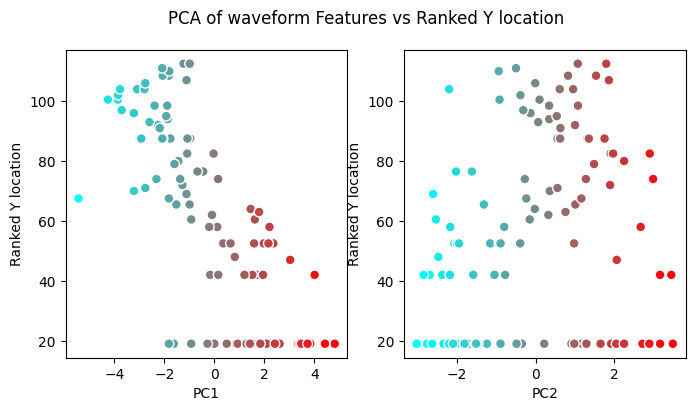

In [31]:
# scatter plot of PC1 and PC2 against ranked y location
y_loc_ranked_no_nan = y_loc_ranked[~nan_ind]
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', 
                                               [(0, (0, 1, 1)), 
                                                (0.5, (0.5, 0.5, 0.5)), 
                                                (1.0, (1, 0, 0))])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(pca_result[:, 0], y_loc_ranked_no_nan, 
                c=pca_result[:, 0], cmap = custom_cmap, 
                alpha=1, s=50, edgecolors='w', linewidths=1)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('Ranked Y location')
axes[1].scatter(pca_result[:, 1], y_loc_ranked_no_nan, 
                c=pca_result[:, 1], cmap = custom_cmap, 
                alpha=1, s=50, edgecolors='w', linewidths=1)
axes[1].set_xlabel('PC2')
axes[1].set_ylabel('Ranked Y location')
plt.suptitle('PCA of waveform Features vs Ranked Y location')
plt.savefig(os.path.join(target_folder, f'Wf_features_PCA_vs_Yloc.pdf'), dpi=300, bbox_inches='tight')

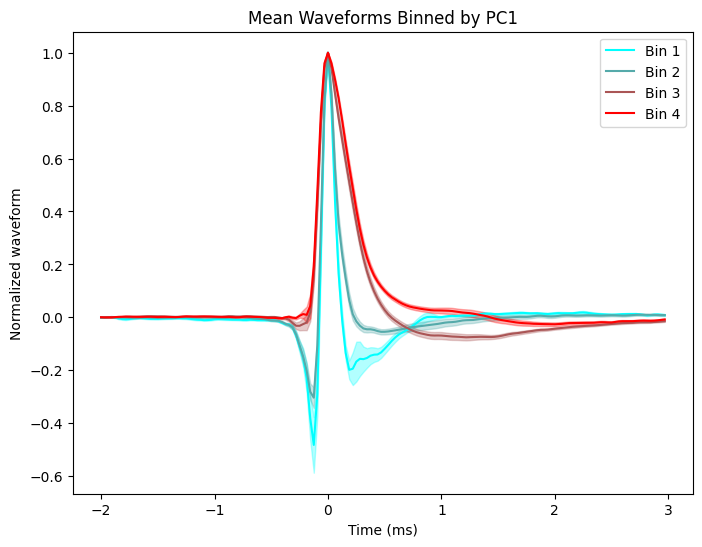

In [32]:
# mean waveforms of binned by PC1
focus_value = pca_result[:, 0]
n_bins = 4
bins = np.linspace(np.min(focus_value), np.max(focus_value), n_bins+1)

fig = plt.figure(figsize=(8, 6))
for bin in range(n_bins):
    bin_ind = (focus_value >= bins[bin]) & (focus_value < bins[bin+1])
    mean_wf = np.nanmean(all_wfs_nl_clean[~nan_ind][bin_ind], axis=0)
    sem_wf = stats.sem(all_wfs_nl_clean[~nan_ind][bin_ind], axis=0, nan_policy='omit')
    color = custom_cmap(bin / (n_bins - 1))
    plt.plot(time, mean_wf, color=color, label=f'Bin {bin+1}')
    plt.fill_between(time, mean_wf - sem_wf, mean_wf + sem_wf, color=color, alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel('Normalized waveform')
plt.title('Mean Waveforms Binned by PC1')
plt.legend()
plt.savefig(os.path.join(target_folder, f'Wf_mean_binned_by_PC1.pdf'), dpi=300, bbox_inches='tight')

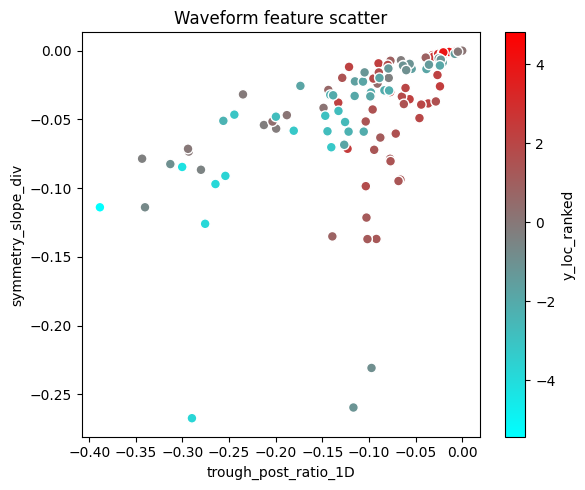

In [34]:
import numpy as np
import matplotlib.pyplot as plt
wf_features['symmetry_slope_div_log'] = np.log((-wf_features['symmetry_slope_div'] + 0.0001))
# Add small Gaussian noise (jitter) to x
x_value = 'trough_post_ratio_1D'
y_value = 'symmetry_slope_div'
x = wf_features[x_value].values[~nan_ind]
y = wf_features[y_value].values[~nan_ind]

# Create scatter plot
fig = plt.figure(figsize=(6, 5))
sc = plt.scatter(x, y, c=pca_result[:, 0], cmap=custom_cmap, s=50, alpha = 1, edgecolor = 'w', linewidth=1)

plt.xlabel(x_value)
plt.ylabel(y_value)
plt.title('Waveform feature scatter')
plt.colorbar(sc, label='y_loc_ranked')
plt.tight_layout()
plt.show()

fig.savefig(fname=os.path.join(target_folder, f'Wf_feature_scatter_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
fig.savefig(fname=os.path.join(target_folder, f'Wf_feature_scatter_{criteria_name}.svg'), dpi=300, bbox_inches='tight')
